A fundamental part of Financial Pricing models is the numeric implementation. We will implement the Binomial Asset Pricing model via two different approaches: using a semi-explicit formula with the expectation of a binomial random variable AND using Monte Carlo simulations

In [ ]:
#Mathematical Finance

import numpy as np
import scipy as sp
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

Simulation of Random Variables

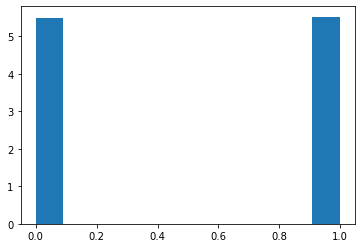

In [ ]:
N = 1000 #Number of simulations

#Bernoulli Random Variable
p = 0.5 #Coin toss probability of success
B = st.bernoulli.rvs(p, size = N)
plt.figure()
plt.hist(B, bins = 'auto', density = True)
plt.show()

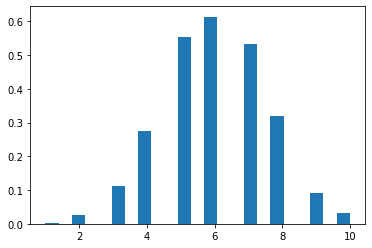

In [ ]:
#Binomial Random Variable
K = 10 #Number of coin tosses
p= 0.6
Bin = st.binom.rvs(K, p, size = N)
plt.figure()
plt.hist(Bin, bins = 'auto', density = True)
plt.show()

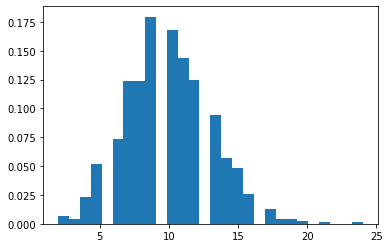

In [ ]:
#Poisson Random Variable
lam = 10
P = st.poisson.rvs(lam, size = N)
plt.figure()
plt.hist(P, bins = 'auto', density = True)
plt.show()

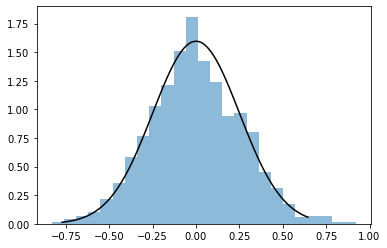

In [ ]:
#Gaussian Random Variable
mu = 0 #Mean
sig = 0.25 #Standard Deviation

G = st.norm.rvs(loc = mu, scale = sig, size = N)
x = np.linspace(st.norm.ppf(0.001,loc = mu, scale = sig),st.norm.ppf(0.995,loc = mu, scale = sig), 100)

plt.figure()
plt.plot(x,st.norm.pdf(x,loc = mu, scale = sig),'k-')
plt.hist(G, bins = 'auto', density = True,alpha=0.5)
plt.show()

Option Pricing in a single-period binomial model

In [ ]:
#External parameters

S0 = 100 #Initial value of the underlying asset
r = 0.05  #Risk-free discount rate 

#Inputs

T = 1  #Maturity time in years


K = 95 #Strike

#Computation of Up-Down probabilities

u = 1.5 #Up factor    u > 1 + r
d = 0.5 #Down factor 0 < d < 1 + r

p = ((1 + r) - d)/(u - d)
q = 1 - p

In [ ]:
#Option Pricing via expectations
#European Call

C = p*max(S0*u - K,0) + q*max(S0*d - K,0)
C *= np.power(1 + r,-1)

print(C)

28.80952380952381


In [ ]:
#Option Pricing via Monte Carlo simulation
#We will simulate N coin tosses, and depending on the result we will compute
#the payoff as max(S0*u-K,0) or max(S0*d -K, 0)
#The value of the option is the average result of the coin tosses

N= 10000

B = st.bernoulli.rvs(p, size = N)

#Payoff = [ max(S0*(u**i)*(d**(1-i)) - K,0) for i in B ]
Payoff = []

for i in range(N):
    if B[i] == 1:
        P = max(S0*u - K,0)
    else:
        P = max(S0*d - K, 0)
    Payoff.append(P)

C_MC = np.mean(Payoff)
C_MC *= np.power(1 + r,-1)
print(C_MC)

28.799047619047617


In [ ]:
#Put Option
P = p*max(K - S0*u ,0) + q*max(K -S0*d,0)
P *= np.power(1 + r,-1)

print(P)

19.28571428571428


In [ ]:
B = st.bernoulli.rvs(p, size = N)

#Payoff = [ max(S0*(u**i)*(d**(1-i)) - K,0) for i in B ]
Payoff = []

for i in range(N):
    if B[i] == 1:
        P = max(K - S0*u ,0)
    else:
        P = max(K -S0*d , 0)
    Payoff.append(P)

P_MC = np.mean(Payoff)
P_MC *= np.power(1 + r,-1)
print(P_MC)

19.5



We compute the value of a European Call Option using the binomial expectation formula:

$$ C_0 = \frac{1}{(1+r_{eff})^M} \sum_{i=0}^M  { M \choose i } p^i q^{M-i} ( S_M - K )_{+}, $$
where $S_M = S_0 \times u^i \times d^{M-i}$.  
We can compute the value of an European Put in a similar way, by substituting the payoff function $(K - S_M)_+$. 

In [ ]:
#Computing the value of a European Call Option in the K-period model

#Output
C = 0 #Call option price

M = 4  #Number of periods

#Dada la tasa de interés efectiva por el periodo [0,T], debemos deducir las tasas
# efectivas para cada periodo [ k-1/N * T, k/N * T ] k=1,...,N.

r_eff = np.power( 1 + r*T ,(1/M)) - 1

print(r_eff)

K = 95 #Strike

#Parámetros internos del modelo binomial

u = 1.05 #Up factor    u > 1 + r_eff
d = 0.94 #Down factor 0 < d < 1 + r_eff

#Cálculo de probabilidades Up-Down

p = ((1 + r_eff) - d)/(u - d)
q = 1 - p

0.012272234429039353


In [ ]:
#Computation using the expectation formula

for i in range(M+1):
    ST = S0*(u**i)*(d**(M-i))
    prob = st.binom.pmf(i,M,p)
    payoff = max(ST - K,0) #Put max(K - ST,0)
    C += prob*payoff

C *= np.power(1 + r_eff,-M)

print(C)

10.53340231391178


In [ ]:
#Computation with Monte Carlo simulation

Payoff = []
Binom = st.binom.rvs(M,p,size = N)

for i in range(N):
    ST = S0*(u**Binom[i])*(d**(M-Binom[i]))
    Payoff.append(max(ST-K,0))

C_MC = np.mean(Payoff)
C_MC *= np.power(1 + r_eff,-M)

print(C_MC)

10.475544935714291


Pricing of a Path Dependent Options via Monte Carlo simulation

Consider an Asian Call Option, whose payoff is given by
$$ (\overline{S}_M - K)_{+}, $$ where $\overline{S}_M := \frac{1}{M+1}\sum_{j=0}^{M} S_i $ is the average of the observed asset prices on each period.

It turns out to be more convenient to compute the value of the option using Monte Carlo simulation.

In [ ]:
Payoff = []
for i in range(N):
    A = S0
    for j in range(M):
        B = st.bernoulli.rvs(p)
        A += S0*(u**B)*(d**(1-B))
    A *= 1/(M+1)
    Payoff.append(max(A - K,0))
    
A_MC = np.mean(Payoff)
A_MC *= np.power(1 + r_eff,-M)

print(A_MC)

5.673295238095243


Pricing of a Barrier-type Option

Up & Out Call Option:
Fix a threshold $B > 0$. If at any point in time between $[0,T]$ the stock value goes above $B$, then the option becomes worthless; otherwsie, the terminal payoff will be $(S_T - K)_{+}$. NOTE: $B > K$.

In [ ]:
Payoff = []

B = 175

for i in range(N):
    A = S0
    P = 0
    n = 0 #Coin toss counter
    while A <= B and n <= M:
        H = st.bernoulli.rvs(p)
        A *= (u**H)*(d**(1-H))
        n+=1
    if n == M+1 and A <= B:
        P = max(A-K,0)
    Payoff.append(P)
        
UO_MC =  np.mean(Payoff)
UO_MC *= np.power(1 + r_eff,-M)


print(UO_MC)

11.89826392571428


In [ ]:
from scipy.optimize import least_squares
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])

def fun(x, u, y):
    return model(x, u) - y

def jac(x, u, y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J

In [ ]:
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


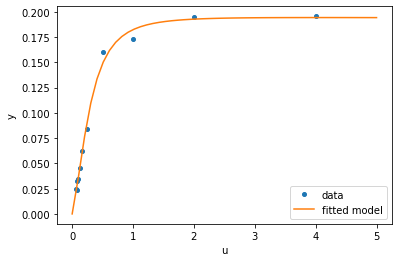

In [ ]:
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

Pricing of American Put Options

Recall from the lectures that in American Call Options it is not optimal to exercise early, so it reduces to an European Call Option. On the other hand, for American Put Options it might be optimal to exercise early.

In [ ]:
#First we compute all the possible terminal values of the stock and their associated payoffs

C = []
for j in range(M+1):
    S = S0 * (u**j) * (d**(M-j))
    C.append(max(0,K - S))

#Backward recursion through the tree
for i in np.arange(M-1,-1,-1):
    for j in range(i+1):
        S = S0 * (u**j) * (d**(i-j))
        C[j] = np.power(1 + r_eff,-1)* (p*C[j+1] + (1-p)*C[j])
        C[j] = max(C[j], K -S)
        
print(C[0])


1.155540408766351


Extracting data from Yahoo! Finance

In [ ]:
url = "https://finance.yahoo.com/quote/%5ERUT/options?p=%5ERUT"

In [ ]:
#pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup
import requests

headers = { 
    'User-Agent'      : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
}
page = requests.get(url, headers = headers, timeout = 5)
page

In [ ]:
soup = BeautifulSoup(page.text, 'html.parser')

In [ ]:
data = []
table = soup.find('table') #find_all
table_body = table.find('tbody')

rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values